# CATE Estimation Disparity Between Minority and Majority Groups

In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import econml
from econml.grf import CausalForest
from RATE import *
# set numpy seed
np.random.seed(0)

In [2]:
NUM_SIMULATIONS = 50  # global constant for number of simulations

In [3]:
global_start_time = time.time()

## Simulated Data Generation

The CATE function is completely different among the minority and majority groups

In [4]:
def gen_imbalanced_data_independentTE(n=4000, propensity=0.5, p_protect=0.1, m_categorical=2, m_continuous=3, noise_var=1.0):
    # imbalanced protected variable
    X_protect = np.random.choice([0,1], size=(n, 1), p=[1-p_protect, p_protect])
    # some categorical
    X_categorical = np.random.choice([0,1], size=(n, m_categorical), p=[0.5, 0.5])
    # some continuous
    X_continuous = np.random.normal(0, 1, size=(n, m_continuous))
    # m = 1+m_categorical+m_continuous
    X = np.concatenate((X_protect, X_categorical, X_continuous), axis=1)
    # random treatment assignment
    W = np.random.choice([0,1], n, p=[1-propensity, propensity])
    # if the treatment effect is linear, then the linear model is correctly specified
    Tau = X_protect[:,0] * (X_categorical[:,0] + X_continuous[:,0]) + (1-X_protect[:, 0]) * (X_categorical[:,1] + X_continuous[:,1])
    Y = np.maximum(np.sum(X, axis=1), 0.0) + W * Tau + np.random.normal(0, np.sqrt(noise_var), n)
    return X, W, Tau, Y

In [5]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_independentTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_independentTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.1075 0.5035 0.0024762748821773543
Some examples of Y: [3.43107971 1.4865937  1.2770569  1.73938342 0.78849849]


In [6]:
print(np.mean(Tau_train)) # has an expectation of 0.6

0.5062278657409308


### Graphing

In [7]:
def eval_MSE_twoGroups(CATE_pred, X, Tau, verbose = False):
    # minority group performance
    if len(np.where(X[:,0] == 1)[0]) != 0:
        CATE_pred_minority = CATE_pred[X[:,0] == 1]
        Tau_minority = Tau[X[:,0] == 1]
        MSE_minority = mean_squared_error(Tau_minority, CATE_pred_minority)
    else:
        MSE_minority = 0.0
    # majority group performance
    if len(np.where(X[:,0] == 0)[0]) != 0:
        CATE_pred_majority = CATE_pred[X[:,0] == 0]
        Tau_majority = Tau[X[:,0] == 0]
        MSE_majority = mean_squared_error(Tau_majority, CATE_pred_majority)
    else:
        MSE_majority = 0.0
    
    MSE_diff = MSE_minority - MSE_majority
    
    if verbose:
        print(f"The MSE on minority group is {MSE_minority: .3f}. The MSE on majority group is {MSE_majority: .3f}. The difference is {MSE_diff: .3f}.")
    return MSE_minority, MSE_majority, MSE_diff 

In [8]:
def plot_MSEdiff_protect(p_protect,  MSE_diff, name=None, custom_yticks=None):
    plt.scatter(p_protect[1:-1], MSE_diff[1:-1], color='blue', s=5)
    plt.axvline(x=0.1, color="black", linestyle='--')
    plt.axvline(x=0.9, color="black", linestyle='--')
    plt.axhline(y=0.0, color="grey", linestyle='--')

    plt.xlabel('Probability of protected variable = 1')
    plt.ylabel('Minority group MSE - Majority group MSE')

    custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [i/2-2 for i in range(9)]  # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_diff vs. p_protect')

    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [9]:
def plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, name = None, custom_yticks=None):
    # also consider log of the ratio
    plt.scatter(p_protect[1:-1], np.array(MSE_minority[1:-1]) / np.array(MSE_majority[1:-1]), color='blue', s=5)
    plt.yscale('log')
    plt.axvline(x=0.1, color="black", linestyle='--')
    plt.axvline(x=0.9, color="black", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    
    plt.xlabel('Probability of protected variable = 1')
    plt.ylabel('Minority group MSE / Majority group MSE')

    custom_xticks = [i/10 for i in range(11)]     # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-2, 1e-1, 1e0, 1e1, 1e2]  # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. p_protect')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [10]:
# generate a 2 by 2 plot.
# 2 plots are how ratio in the two MSEs changes with weight on minority group for training and testing sets
# the other 2 are "ROC curves with MSE on minority group against MSE on majority group"

def plot_MSE(mu_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(mu_list, np.array(train_min) / np.array(train_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(mu_list, np.array(test_min) / np.array(test_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[0], optimal_points[1], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_3, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/2+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_4, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

## Doubly Robust Pseudo-outcome

In [11]:
# TODO: check if reweighting is done this way!
# Change to AIPW since randomized control
def DR_linear_estimator(X, W, Y, weight_minority=1.0):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    # propensity = LinearRegression(n_jobs=-1)
    # control_nuissance = LinearRegression(n_jobs=-1)
    # treatment_nuissance = LinearRegression(n_jobs=-1)
    
    # use non-parametric for nuissance
    # control_nuissance = econml.grf.RegressionForest(n_estimators=200)
    # treatment_nuissance = econml.grf.RegressionForest(n_estimators=200)

    # propensity.fit(X, W, sample_weight = sample_weights)
    # control_nuissance.fit(X[W==0], Y[W==0], sample_weight = sample_weights[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1], sample_weight = sample_weights[W==1])
    # control_nuissance.fit(X[W==0], Y[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1])

    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/propensity.predict(X) - (1-W)*(Y-control_nuissance.predict(X))/(1-propensity.predict(X))
    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/0.5 - (1-W)*(Y-control_nuissance.predict(X))/0.5
    # pseudo_outcome_Y = treatment_nuissance.predict(X).flatten() - control_nuissance.predict(X).flatten() + W*(Y-treatment_nuissance.predict(X).flatten())/0.5 - (1-W)*(Y-control_nuissance.predict(X).flatten())/0.5
    pseudo_outcome_Y = get_scores(X, Y, W, e=np.mean(W), m=None, params={'n_estimators': 200}, scoring_type="AIPW")
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X, pseudo_outcome_Y, sample_weight = sample_weights)
    return model

In [12]:
model = DR_linear_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)
print(np.abs(CATE_pred - Tau_train))

[0.16112842 0.35429275 0.09895268 ... 0.14317048 2.95102756 0.07659472]


In [13]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  2.085. The MSE on majority group is  0.026. The difference is  2.059.


(2.085465327694632, 0.026260114728353684, 2.0592052129662783)

In [14]:
eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test, verbose = True)

The MSE on minority group is  2.311. The MSE on majority group is  0.025. The difference is  2.286.


(2.3112898969143783, 0.025297390712245047, 2.2859925062021333)

In [15]:
def run_DR_linear_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_independentTE(p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_independentTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = DR_linear_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train), X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [17]:
start_time = time.time()
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation()
print("--- %s seconds ---" % (time.time() - start_time))
# stddev of sample mean is stddev of sample divided by sqrt(sample size)
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

--- 45.968987703323364 seconds ---
2.0110206499950385 0.023469760041527118 1.6143559705465915 2.3180493593200606
1.993193466387273 0.04705847927446593 1.2999246407905407 2.815229953975361


In [18]:
# plot difference in MSE with respect to p_protect
p_protect = []
MSE_diff = []
MSE_minority = []
MSE_majority = []
start_time = time.time()
for i in range(1, 100):
    p = i / 100
    p_protect.append(p)
    _, _, _, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(p_protect=p)
    MSE_minority.append(np.mean(MSE_minority_test))
    MSE_majority.append(np.mean(MSE_majority_test))
    MSE_diff.append(np.mean(MSE_diff_test))
print("--- %s seconds ---" % (time.time() - start_time))

--- 5009.866780042648 seconds ---


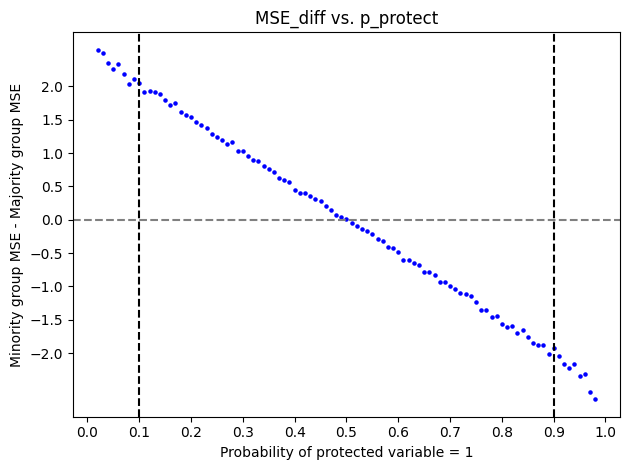

In [19]:
plot_MSEdiff_protect(p_protect, MSE_diff, "independentTau_DRLearner_linearEstimator_MSEdiffOnProb")

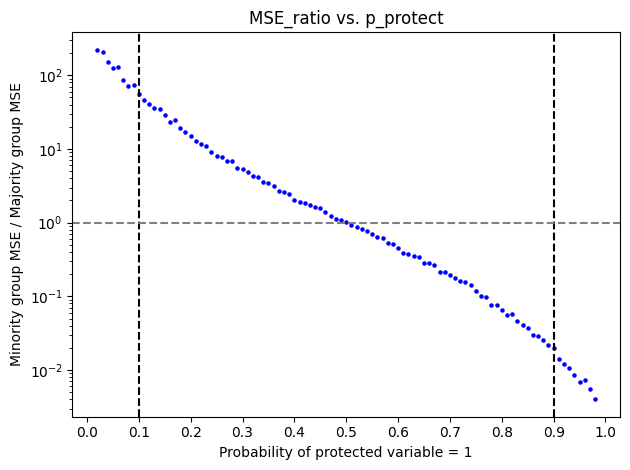

In [20]:
plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, "independentTau_DRLearner_linearEstimator_MSEratioOnProb")

In [16]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in (0,20]
    mu_list.append(i/4)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(weight=i/4)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

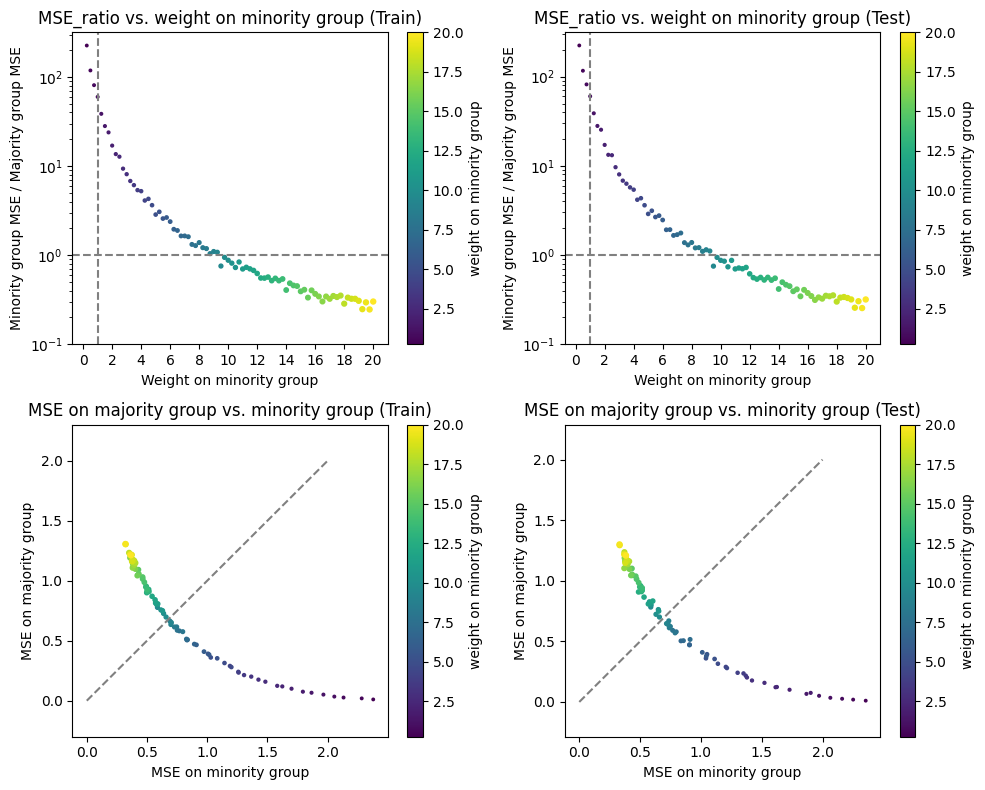

In [17]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'independentTau_DRLearner_linearEstimator_MSEViz.png', max_MSE=2.0)

## Causal Forest

In [18]:
def causalForest_estimator(X, W, Y, weight_minority=1.0, n_estimators=200):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    model = CausalForest(n_estimators=n_estimators)
    model.fit(X, W, Y, sample_weight=sample_weights)
    return model

In [19]:
model = causalForest_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)[:,0]
print(np.abs(CATE_pred - Tau_train))
# seems reasonable

[0.3060318  0.01360845 0.25782829 ... 0.13309987 2.809641   0.49048604]


In [20]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  1.544. The MSE on majority group is  0.096. The difference is  1.448.


(1.5439946842062862, 0.09641602912424432, 1.4475786550820418)

In [21]:
CATE_pred_test = model.predict(X_test)[:,0]
eval_MSE_twoGroups(CATE_pred_test, X_test, Tau_test, verbose = True)

The MSE on minority group is  1.988. The MSE on majority group is  0.107. The difference is  1.882.


(1.98813993598352, 0.10662101221340752, 1.8815189237701124)

In [22]:
def run_causalForest_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.1, noise_var=1.0, n=4000):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_independentTE(n=n, p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_independentTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [23]:
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation()
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

1.4225649173670651 0.02238632121056933 1.0971296210131911 1.695310243148763
1.5936739709244008 0.04751048448579732 0.9869081609535111 2.412735291928645


In [29]:
# plot difference in MSE with respect to p_protect
p_protect = []
MSE_diff = []
MSE_minority = []
MSE_majority = []
for i in range(1, 100):
    p = i / 100
    p_protect.append(p)
    _, _, _, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(p_protect=p)
    MSE_minority.append(np.mean(MSE_minority_test))
    MSE_majority.append(np.mean(MSE_majority_test))
    MSE_diff.append(np.mean(MSE_diff_test))

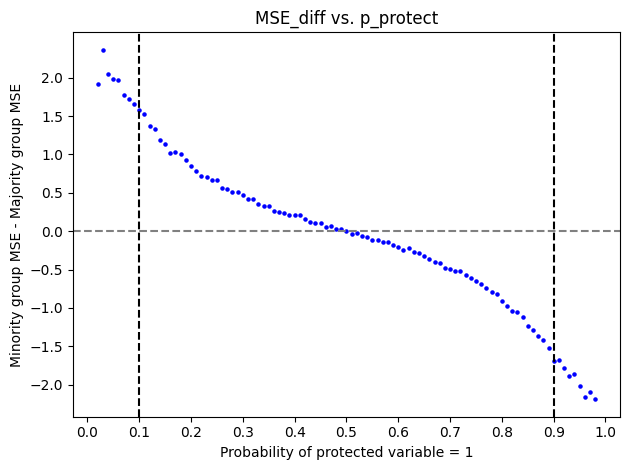

In [30]:
plot_MSEdiff_protect(p_protect, MSE_diff, "independentTau_causalForest_MSEdiffOnProb")

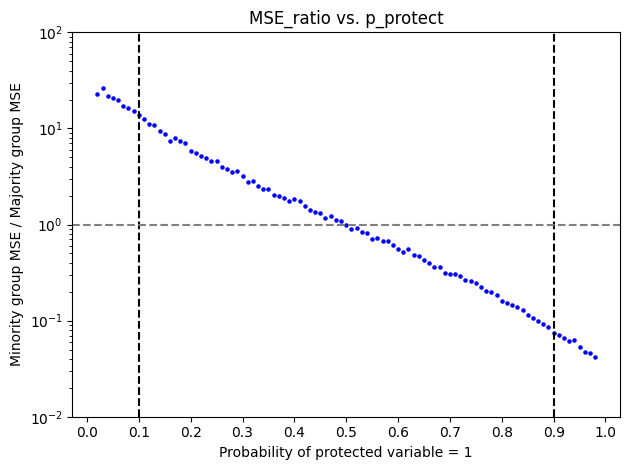

In [31]:
plot_MSEratio_protect(p_protect, MSE_minority, MSE_majority, "independentTau_causalForest_MSEratioOnProb")

In [69]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
start_time = time.time()
for i in range(1, 61):
    # mu in [0.5,30]
    mu_list.append(i/2)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i/2)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))
print("--- %s seconds ---" % (time.time() - start_time))

--- 1629.2310659885406 seconds ---


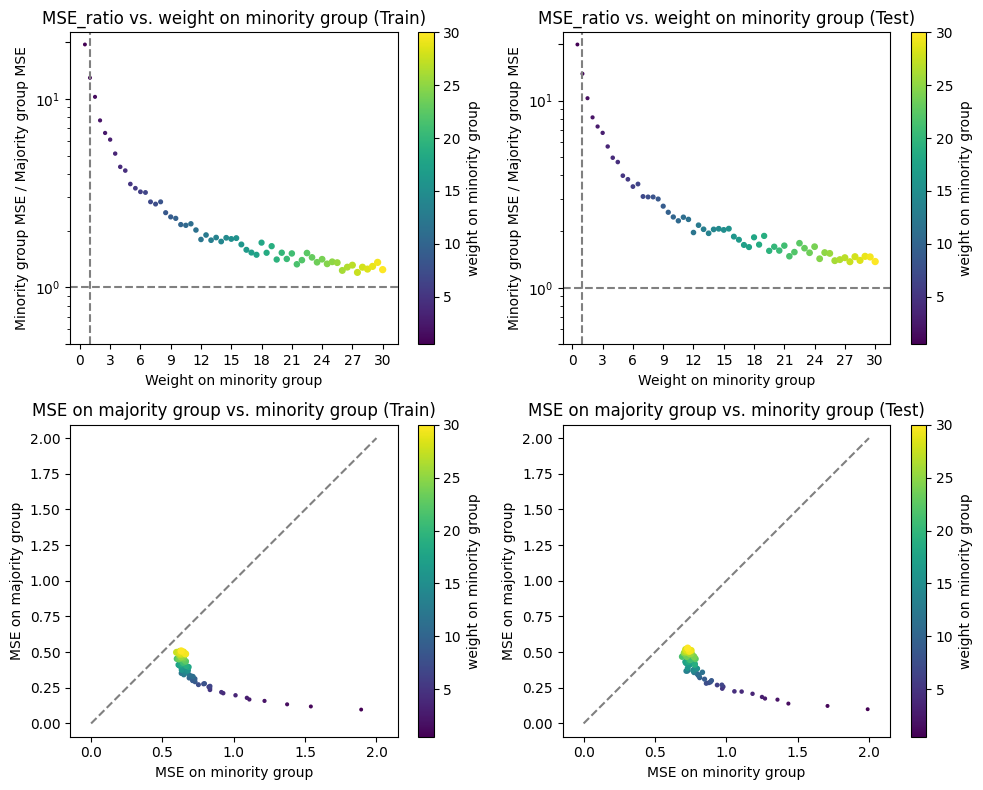

In [70]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'independentTau_causalForest_MSEViz.png', custom_xticks=[i*3 for i in range(11)], custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE=2)
# custom_xticks=[i*8 for i in range(11)], custom_yticks=[i/2 for i in range(-1, 5, 1)], min_MSE=0, max_MSE=3)

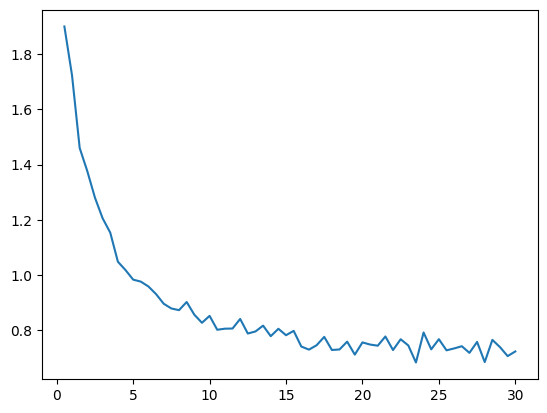

In [26]:
plt.plot(mu_list, MSE_minority_test_list)

In [27]:
MSE_minority_test_list

[1.9005029621932732,
 1.7230101840218652,
 1.4601104391652984,
 1.3757658706672868,
 1.2797766641319093,
 1.2053590505673173,
 1.1531792968628634,
 1.0477630273572358,
 1.0173518602001106,
 0.9827260093165644,
 0.9755936995680302,
 0.9578745394512141,
 0.9301417688153206,
 0.8952393469597193,
 0.8781777028028102,
 0.8721694282391339,
 0.9017392825840796,
 0.8557385269728363,
 0.826383745926513,
 0.8513758276850545,
 0.8011016051424028,
 0.8049616018471155,
 0.8055401673185885,
 0.8402574943527241,
 0.7874615253000201,
 0.7949118535628124,
 0.8160415537443219,
 0.7778135430253479,
 0.8046251700871759,
 0.7812731861891332,
 0.7970553843226118,
 0.7402835413566478,
 0.7290796315650866,
 0.7448805795712522,
 0.7752282817654421,
 0.7277318459269381,
 0.7297048551270372,
 0.7579702778530408,
 0.7109729796987391,
 0.7552482363393779,
 0.7474605774408234,
 0.7432751102368479,
 0.7766492294725702,
 0.7275140985139217,
 0.7666735782246202,
 0.7441957016528943,
 0.6824727826936205,
 0.79119467862

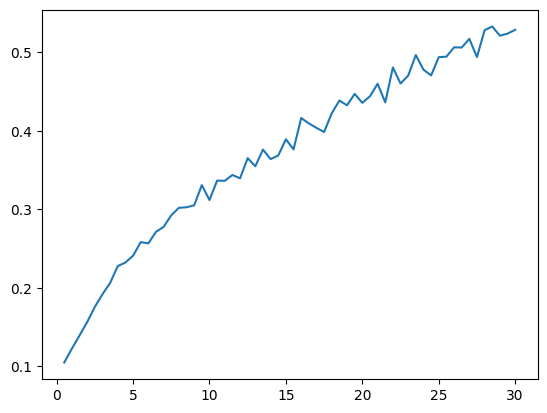

In [28]:
plt.plot(mu_list,MSE_majority_test_list)

In [29]:
MSE_majority_test_list

[0.10487525566999603,
 0.1225723570044865,
 0.139313541071909,
 0.15643169064928727,
 0.17575957377113938,
 0.1919008435625754,
 0.20623262149986352,
 0.22771417292374108,
 0.2323149357240761,
 0.24093182187454876,
 0.25827647411971777,
 0.2567166489785707,
 0.27138807917252483,
 0.27777610294675037,
 0.2925115895755366,
 0.3020539474951052,
 0.3027235965280223,
 0.30524994934397787,
 0.3309839246831963,
 0.31195143205469383,
 0.3367048753524503,
 0.336438216847481,
 0.34387417958991684,
 0.3395861897074989,
 0.3653699215340275,
 0.35498879964700103,
 0.3762090488927047,
 0.3641286534479867,
 0.36868110259346165,
 0.3893746382643851,
 0.37645665626811314,
 0.4165025300420503,
 0.4096307479375628,
 0.4039121926870715,
 0.3986344208553726,
 0.4225858972747472,
 0.43878196975690764,
 0.4327254317338894,
 0.4472656900266013,
 0.4358464612682605,
 0.4442478578298775,
 0.4601225897752903,
 0.43643002172611817,
 0.4808751410962021,
 0.46050679357162816,
 0.47056617192839567,
 0.49669094841092

In [30]:
model = causalForest_estimator(X_train, W_train, Y_train)
model.feature_importances()

array([1.86628649e-03, 8.37758307e-04, 3.45907929e-02, 1.48919101e-02,
       9.36556534e-01, 1.12567186e-02])

In [31]:
model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=20.0)
model.feature_importances()

array([0.01929466, 0.0111103 , 0.02521835, 0.6277992 , 0.25681357,
       0.05976391])

# WGAN Synthetic Data Augmentation

In [32]:
import pandas as pd

In [33]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_independentTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_independentTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.1, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.10275 0.5055 0.010791883295182136
Some examples of Y: [ 1.81220957 -1.09050158  0.090705    3.17027446  2.40299769]


In [34]:
train_concat = np.column_stack((np.array(W_train), np.array(X_train), np.array(Y_train)))
df_train = pd.DataFrame(train_concat, columns=['t', 'cat1', 'cat2', 'cat3', 'cont1', 'cont2', 'cont3', 'y'])

In [35]:
df_train.to_csv('df_independent_train.csv', index=False)

## After balancing protected variable

In [36]:
df_generated = pd.read_csv("df_independent_generated.csv")

In [37]:
tau_generated = df_generated.cat1 * (df_generated.cat2 + df_generated.cont1) + (1-df_generated.cat1) * (df_generated.cat3 + df_generated.cont2)

In [38]:
pred_generated = (df_generated.y - df_generated.y_cf)*df_generated.t + (df_generated.y_cf - df_generated.y)*(1-df_generated.t)

In [39]:
mean_squared_error(tau_generated, pred_generated)

1.8805527432137248

In [40]:
np.corrcoef(tau_generated, pred_generated)[0, 1]

0.5100598152051918

## Synthetic Data Augmentation

In [66]:
def plot_MSE_aug(ratio_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.0):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(ratio_list, np.array(train_min) / np.array(train_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(ratio_list, np.array(test_min) / np.array(test_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.colorbar(scatter_3, label='minority group size / majority group size')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*5+3)
    plt.colorbar(scatter_4, label='minority group size / majority group size')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [61]:
df_generated = pd.read_csv("df_independent_generated.csv")

In [62]:
df_generated_minority = df_generated[df_generated["cat1"] == 1]

In [63]:
df_generated_minority.shape

(559700, 10)

Try finer detail increments and run multiple times to get an average, also label the points with the amount of synthetic data added if possible

In [64]:
ratio_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
num_min = np.sum(X_train[:,0] == 1)
num_maj = np.sum(X_train[:,0] == 0)
assert(num_min + num_maj == 4000)

start_time = time.time()
for i in range(81):
    # everytime add 80 more minority data point to training set
    ratio_list.append((num_min+i*80)/num_maj)

    MSE_minority_train_temp, MSE_majority_train_temp, MSE_diff_train_temp = [], [], []
    MSE_minority_test_temp, MSE_majority_test_temp, MSE_diff_test_temp = [], [], []
    for j in range(NUM_SIMULATIONS):
        if i != 0:
            df_sampled = df_generated_minority.sample(80*i)
            X = np.vstack((X_train,df_sampled[["cat1","cat2","cat3","cont1","cont2","cont3"]].values))
            W = np.hstack((W_train,df_sampled["t"].values))
            Y = np.hstack((Y_train,df_sampled["y"].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
        model = causalForest_estimator(X, W, Y)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train_temp.append(MSE_minority)
        MSE_majority_train_temp.append(MSE_majority)
        MSE_diff_train_temp.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test_temp.append(MSE_minority)
        MSE_majority_test_temp.append(MSE_majority)
        MSE_diff_test_temp.append(MSE_diff)
    
    MSE_minority_train_list.append(np.mean(MSE_minority_train_temp))
    MSE_majority_train_list.append(np.mean(MSE_majority_train_temp))
    MSE_diff_train_list.append(np.mean(MSE_diff_train_temp))
    
    MSE_minority_test_list.append(np.mean(MSE_minority_test_temp))
    MSE_majority_test_list.append(np.mean(MSE_majority_test_temp))
    MSE_diff_test_list.append(np.mean(MSE_diff_test_temp))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 3525.163232088089 seconds ---


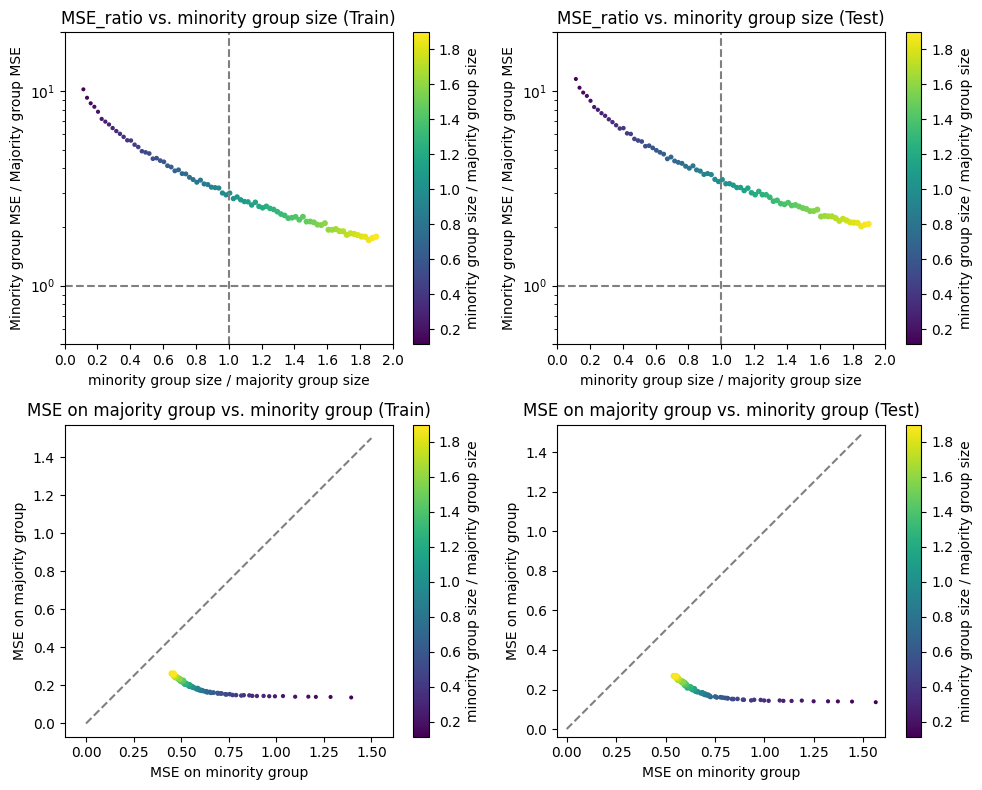

In [67]:
plot_MSE_aug(ratio_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'independentTau_causalForest_WGANAug_MSEViz.png',
         custom_xticks=[i/5 for i in range(0, 11, 1)], custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE=1.5)

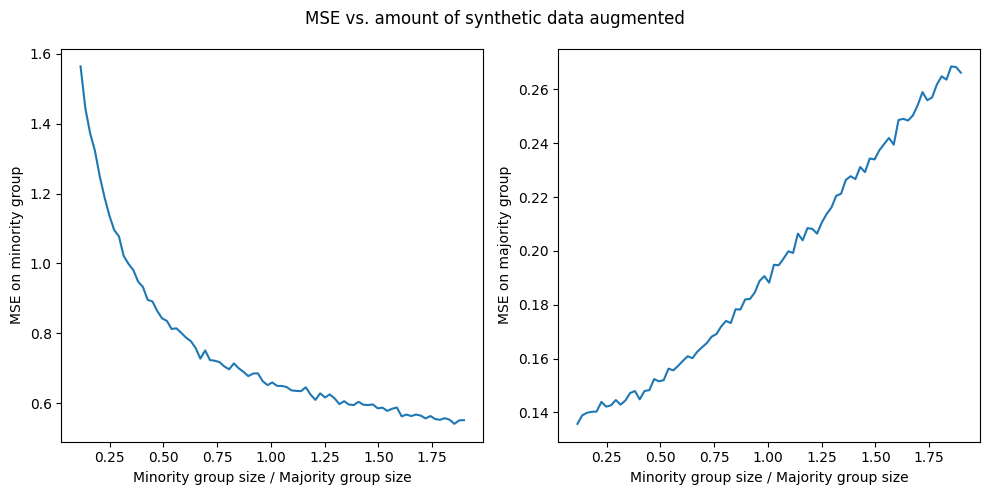

In [68]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ratio_list, MSE_minority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_minority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
# plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
# plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(ratio_list, MSE_majority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_majority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_majority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
# plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
# plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on majority group')

fig.suptitle('MSE vs. amount of synthetic data augmented') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("independentTau_MSE_augratio_best_fit", dpi=200)
plt.show()


### End of Notebook

In [ ]:
print("--- %s seconds ---" % (time.time() - global_start_time))